In [9]:
import sys
sys.path.append('../../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Input 
from tensorflow.keras.optimizers import Adam 

from utils.processing.v02.dataset import TradingDataset

In [10]:
SEQUENCE_LENGTH = 9
PREDICTION_LENGTH = 5
SHIFT_SIZE = 3
BATCH_SIZE = 32

# Loading the Dataframe

In [11]:
df = pd.read_csv('../../pred_data.csv')
df.tail()

,DATETIME,OPEN,HIGH,LOW,CLOSE,VOLUME,EMA,RSI,MACD,SIGNAL_LINE,UPPER_BAND,LOWER_BAND,BOLLINGER_PERCENT_B,ATR
14995,2025-03-31 19:00:00,1.07938,1.08155,1.07846,1.08112,3475,1.08137,48.52,-0.00014,0.00036,1.08218,1.08484,1.39699,0.00187
14996,2025-03-31 20:00:00,1.08112,1.08172,1.08075,1.08142,2364,1.08138,50.14,-0.00012,0.00024,1.08218,1.08484,1.28562,0.00187
14997,2025-03-31 21:00:00,1.08142,1.08174,1.08065,1.08144,2397,1.08138,50.25,-0.00010,0.00015,1.08215,1.08483,1.26512,0.00191
14998,2025-03-31 22:00:00,1.08144,1.08192,1.08114,1.08135,2392,1.08138,49.71,-0.00009,0.00006,1.08210,1.08480,1.27860,0.00189
14999,2025-03-31 23:00:00,1.08136,1.08167,1.08090,1.08162,345,1.08141,51.40,-0.00006,-0.00001,1.08198,1.08452,1.14080,0.00180


In [12]:
ts = df.copy()
ts['DATETIME'] = pd.to_datetime(ts['DATETIME'])
ts = ts.set_index('DATETIME')
ts.sort_index(inplace=True)
ts = ts.loc['2024-05-01 00:00:00':]
ts = ts[:-20]
print(ts.shape)
ts.tail()

(5652, 13)


,OPEN,HIGH,LOW,CLOSE,VOLUME,EMA,RSI,MACD,SIGNAL_LINE,UPPER_BAND,LOWER_BAND,BOLLINGER_PERCENT_B,ATR
DATETIME,,,,,,,,,,,,,
2025-03-28 22:00:00,1.08251,1.08356,1.08247,1.08276,1049,1.08102,68.36,0.00107,0.00060,1.07990,1.08389,0.28371,0.00171
2025-03-31 00:00:00,1.08203,1.08270,1.08114,1.08137,500,1.08106,57.30,0.00100,0.00073,1.08001,1.08403,0.66139,0.00169
2025-03-31 01:00:00,1.08159,1.08218,1.08049,1.08203,1669,1.08119,60.56,0.00099,0.00083,1.08014,1.08425,0.53961,0.00166
2025-03-31 02:00:00,1.08203,1.08288,1.08105,1.08231,2343,1.08134,61.89,0.00099,0.00090,1.08030,1.08448,0.51915,0.00171
2025-03-31 03:00:00,1.08231,1.08410,1.08226,1.08410,2857,1.08171,69.08,0.00112,0.00096,1.08056,1.08500,0.20290,0.00176


# Feature Engineering

### Créations des colonnes avec les valeurs prix de cloture décalées de 24h __Xi = (X[t - i])__

In [13]:
dataset = TradingDataset(ts, shift_size=SHIFT_SIZE, sequence_length=SEQUENCE_LENGTH)
dataset.prepare_data()

# Préparation des données de modélisation

In [14]:
X, y = dataset.feature_sequence, dataset.target_sequence

In [15]:
X, y = np.array(X), np.array(y)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### Compilation du modèle

In [23]:
lstm_model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),    
    LSTM(256),
    Dense(8, activation='relu'),
    Dense(3, activation='linear')
])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.00001, weight_decay = 1e-5),
    loss='mse'
)
lstm_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 256)            │       304,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,211 (1.17 MB)

 Trainable params: 306,211 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

### Apprentissage

In [24]:
# Entraînement du modèle
history = lstm_model.fit(
    X_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=100, 
    validation_data=(X_test, y_test), 
    verbose=1)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.3853 - val_loss: 0.0371
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0589 - val_loss: 0.0169
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0237 - val_loss: 0.0131
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0173 - val_loss: 0.0101
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0133 - val_loss: 0.0077
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0106 - val_loss: 0.0059
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0088 - val_loss: 0.0047
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0080 - val_loss: 0.0042
Epoch 9/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0073 - val_loss: 0.0039
Epoch 10/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0066 - val_loss: 0.0037
Epoch 11/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0063 - val_loss: 0.0034
Epoch 12/100
141/141 ━━━━━━━━━

## Evaluation du modèle

### Courbe d'apprentissage

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


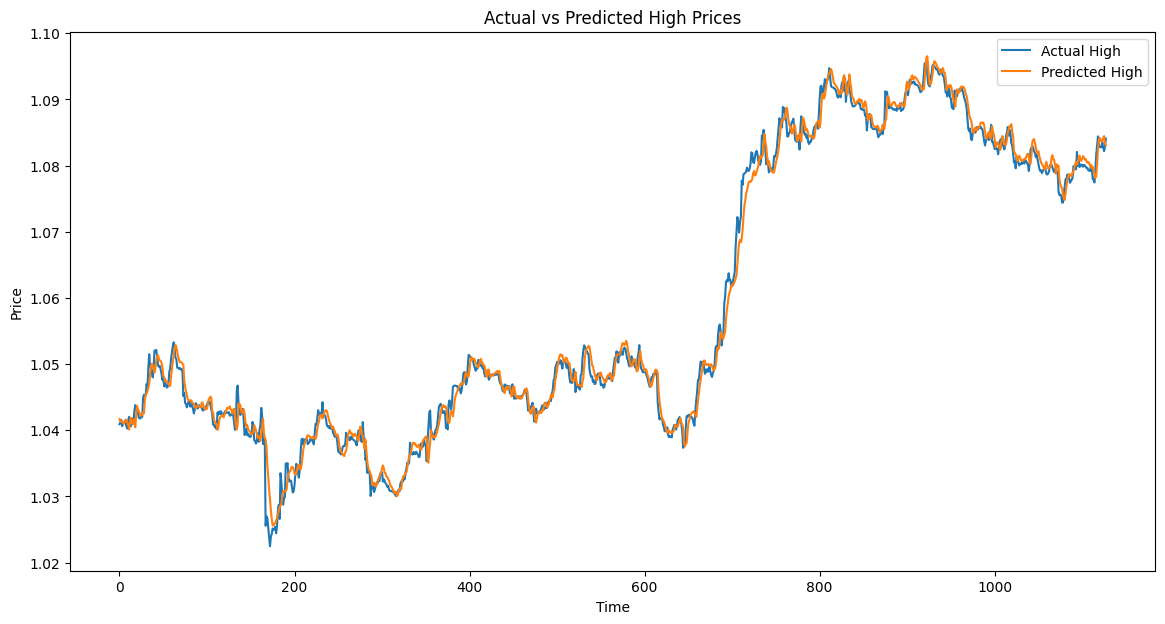

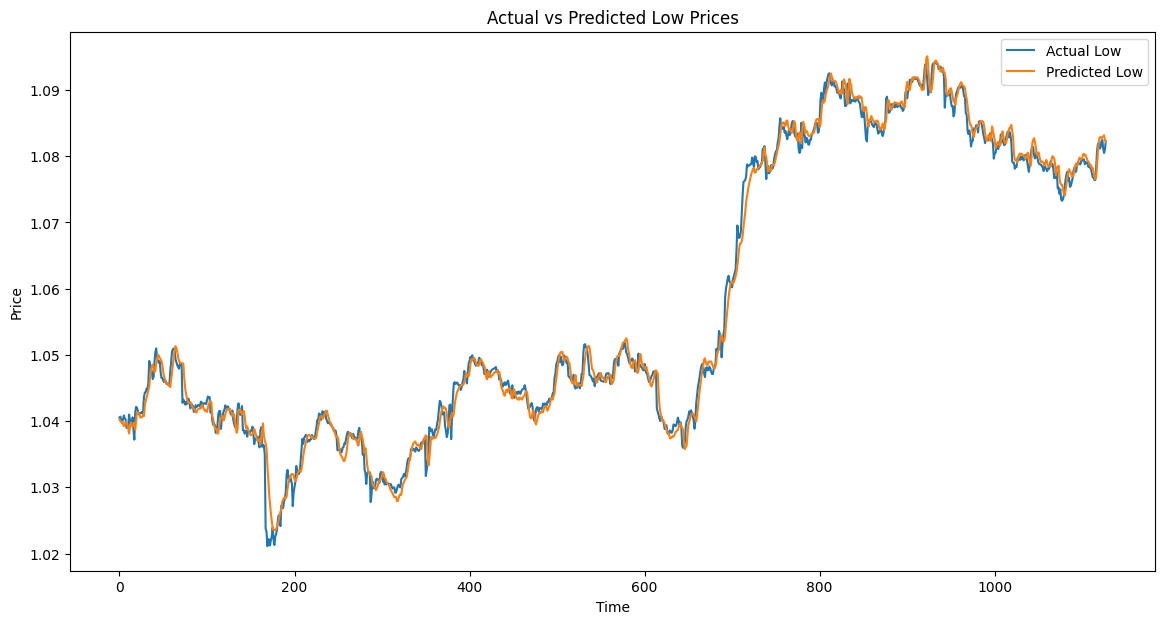

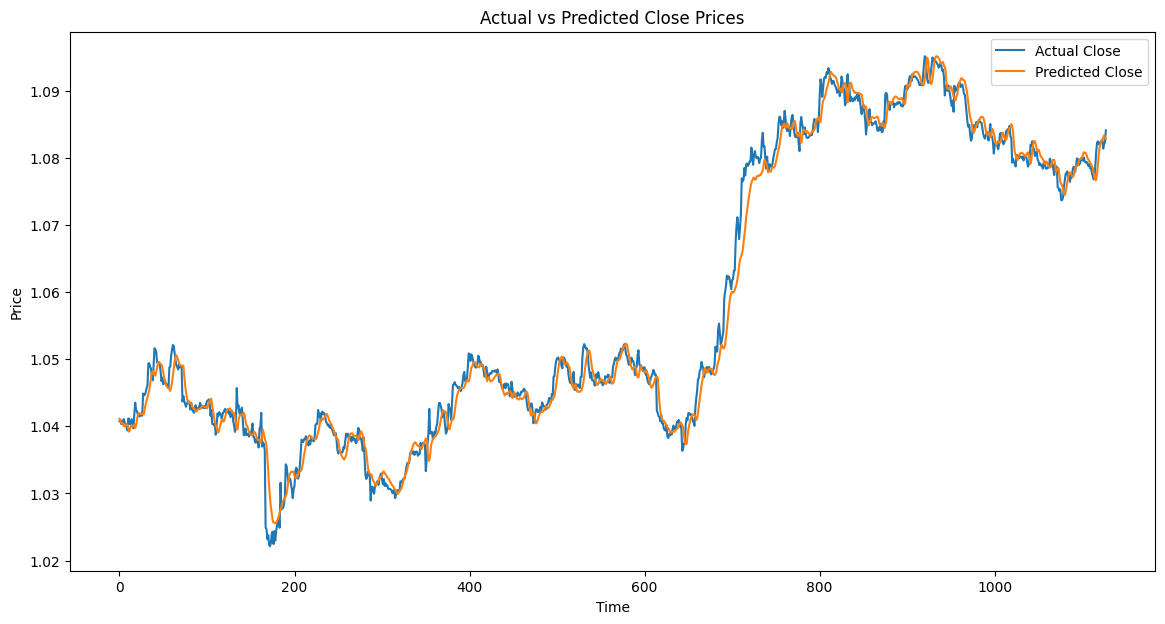

In [25]:
# Prédiction sur les données de test
predictions = history.model.predict(X_test)
predictions = dataset.target_scaler.inverse_transform(predictions)  # Inverser la normalisation

# Comparaison des prédictions avec les vraies valeurs
y_test_actual = dataset.target_scaler.inverse_transform(y_test)

# plot actual vs prediction for each feature
features = ['High', 'Low', 'Close']
for i, feature in enumerate(features):
    plt.figure(figsize=(14, 7))
    plt.plot(y_test_actual[:, i], label=f'Actual {feature}')
    plt.plot(predictions[:, i], label=f'Predicted {feature}')
    plt.title(f'Actual vs Predicted {feature} Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


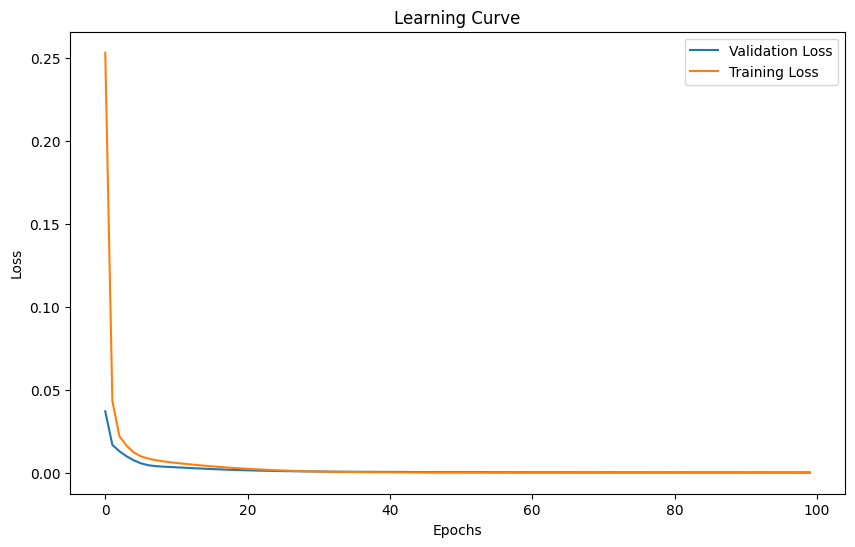

In [26]:
# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Metriques d'évaluation

In [27]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test_actual, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test_actual, predictions)
print(f'Mean Absolute Error: {mae}')

# Calculate RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# R2
print('RSquared : ', '{:.2%}'.format(r2_score(y_test_actual, predictions)))

Mean Squared Error: 3.647757214756633e-06
Mean Absolute Error: 0.001316643178175525
Root Mean Squared Error: 0.0019099102635350784
RSquared :  99.19%


## Sauvegarde du model

In [28]:
history.model.save('../../models/test/best_model_EURUSD_candle.keras')
print('Model saved!!')

Model saved!!


In [22]:
# ts.to_csv('../../notebooks/inference/datasets/eur_usd_2024_03_2025.csv', index=True)